In [71]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
from pytz import timezone

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, Normalizer, RobustScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.utils.np_utils import to_categorical
from keras import optimizers
import talib

In [2]:
# Fix the random seed to reproducibility
# np.random.seed(7)

In [3]:
def get_CU():
    import dovahkiin as dk
    dp = dk.DataParser()
    X = dp.get_data("cu")
    return X

In [4]:
def get_SP500():
    import pandas_datareader as pdr    
    SP500 = pdr.get_data_yahoo('^GSPC')
    return SP500

In [5]:
def get_X_data():
    import dovahkiin as dk
    dp = dk.DataParser()
    X = dp.get_data("cu")
    return X

In [6]:
X = get_X_data()

## Add Features

In [7]:
high = X.high.values
low = X.low.values
close = X.close.values
volume = X.volume.astype(np.float64).values

In [8]:
# Min Max Scaler
X["%K"], X["%D"] = talib.STOCHF(X.high.values, X.low.values, X.close.values)
_, X["Slow %D"] = talib.STOCH(X.high.values, X.low.values, X.close.values)
X["RSI"] = talib.RSI(close)
X["WilliamsR"] = talib.WILLR(X.high.values, X.low.values, X.close.values)
X["-DI"] = talib.MINUS_DI(high, low, close)
X["+DI"] = talib.PLUS_DI(high, low, close)
X["CMO"] = talib.CMO(close)
X["AroonOSC"] = talib.AROONOSC(high, low)
X["ADX"] = talib.ADX(high, low, close)
X["AroonDown"], X["AroonUp"] = talib.AROON(high, low)
X["ADXR"] = talib.ADXR(high, low, close)

_top, _mid, _bot = talib.BBANDS(close)
diff = _top - _bot
diff[(_top - _bot) < 1] = 1
X["%B"] = (X.close - _bot)/diff
X["UltimateOscillator"] = talib.ULTOSC(high, low, close)
X["MFI"] = talib.MFI(high, low, close, volume)

# Scale the same as raw prices
"""
X["DEMA"] = talib.DEMA(close)
X["EMA"] = talib.EMA(close)
X["kAMA"] = talib.KAMA(close)
X["TEMA"] = talib.TEMA(close)
X["TRIMA"] = talib.TRIMA(close)
X["WMA"] = talib.WMA(close)
X["MA"] = talib.MA(close)
X["MAMA"], _ = talib.MAMA(close)
X["BBTop"], X["BBMid"], X["BBBot"] = talib.BBANDS(close)
X["HHV"] = talib.MAX(close)
X["LLV"] = talib.MIN(close)
X["ParabolicSAR"] = talib.SAR(high, low)

# No Scaling Needed
X["BOP"] = talib.BOP(X.open.values, high, low, close)
X["PVI"] = (close - X.open.values) / (high - low)

# Scale as percentage
X["ROC"] = talib.ROC(X.close.values)

# No Sure what to do
X["Momentum"] = talib.MOM(X.close.values)
X["CCI"] = talib.CCI(high, low, close)
X["APO"] = talib.APO(close)
X["-DM"] = talib.MINUS_DM(high, low)
X["+DM"] = talib.PLUS_DM(high, low)
X["ATR"] = talib.ATR(high, low, close)
X["BBWidth"] = X["BBTop"] - X["BBBot"]
X["MACD"], X["MACDSig"], X["MACDHist"] = talib.MACD(close)
X["PPO"] = talib.PPO(close)
X["ADOscillator"] = talib.ADOSC(high, low, close, volume)
X["TRIX"] = talib.TRIX(close)
""";


## Divide Data into Train and Test

In [9]:
X_train = X["2012":"2015"]
X_test = X["2016":]
print("Test: {:.2f}%".format(100 * len(X_test)/len(X["2012":])))
print("Train: {:.2f}%".format(100 * len(X_train)/len(X["2012":])))

Test: 33.35%
Train: 66.65%


In [10]:
len(X_test)

166845

In [11]:
len(X_train)

333465

In [12]:
X.shape

(958635, 22)

## Normalization of Data

In [13]:
assert(not (X["2012":] == np.inf).any().any())

In [14]:
scalers = {
    "%K": MinMaxScaler(),
    "%D": MinMaxScaler(),
    "Slow %D": MinMaxScaler(),
    "RSI": MinMaxScaler(),
    "WilliamsR": MinMaxScaler(),
    "-DI": MinMaxScaler(),
    "+DI": MinMaxScaler(),
    "CMO": MinMaxScaler(),
    "AroonOSC": MinMaxScaler(),
    "ADX": MinMaxScaler(),
    "AroonDown": MinMaxScaler(),
    "AroonUp": MinMaxScaler(),
    "ADXR": MinMaxScaler(),
    "UltimateOscillator": MinMaxScaler(),
    "MFI": MinMaxScaler(),
    "%B": MinMaxScaler()
}

In [15]:
del X_train['open']
del X_train['high'] 
del X_train['low']
del X_train['close']
del X_train['volume']
del X_train['openint']

del X_test['open']
del X_test['high'] 
del X_test['low']
del X_test['close']
del X_test['volume']
del X_test['openint']

In [16]:
scaler = MinMaxScaler()

In [17]:
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)

In [18]:
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

## AutoEncoder

In [84]:
from keras.layers import Input, Dense
from keras.models import Model

In [96]:
def train_simple_autoencoder(encoder):
    encoding_dim = 8 # 54 dim -> 16 dim
    input_layer = Input(shape=(X_train.shape[1],))
    
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(X_train.shape[1])(encoded)
    # this model maps an input to its reconstruction
    autoencoder = Model(input_layer, decoded)
    
    encoded_input = Input(shape=(encoding_dim,))
    encoder = Model(input_layer, encoded)
    
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    autoencoder.compile(optimizer="adadelta", loss='mse')
    history = autoencoder.fit(X_train.values, X_train.values, epochs=100, batch_size=32, validation_split=0.2, shuffle=False)
    
    return (history, autoencoder, encoder, decoder)

In [157]:
def train_deep_autoencoder(dim=8):
    encoding_dim = 8 # 54 dim -> 16 dim
    input_layer = Input(shape=(X_train.shape[1],))
    
    encoded = Dense(int(X_train.shape[1]), activation='relu')(input_layer)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    
    decoded = Dense(encoding_dim*2, activation='sigmoid')(encoded)    
    decoded = Dense(X_train.shape[1])(decoded)
    
    # this model maps an input to its reconstruction
    autoencoder = Model(input_layer, decoded)
    
    encoded_input = Input(shape=(encoding_dim,))
    encoder = Model(input_layer, encoded)
    
    decoder_layer2 = autoencoder.layers[-2]
    decoder_layer1 = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer1(decoder_layer2(encoded_input)))
    
    autoencoder.compile(optimizer="adadelta", loss='mse')
    history = autoencoder.fit(X_train.values, X_train.values, epochs=100, batch_size=32, validation_split=0.2, shuffle=False)
    
    return (history, autoencoder, encoder, decoder)

In [158]:
deep_results = train_deep_autoencoder()

Train on 266772 samples, validate on 66693 samples
Epoch 1/100
266772/266772 [==============================] - 16s - loss: 0.0179 - val_loss: 0.0044
Epoch 2/100
266772/266772 [==============================] - 16s - loss: 0.0036 - val_loss: 0.0027
Epoch 3/100
266772/266772 [==============================] - 16s - loss: 0.0028 - val_loss: 0.0023
Epoch 4/100
266772/266772 [==============================] - 16s - loss: 0.0023 - val_loss: 0.0018
Epoch 5/100
266772/266772 [==============================] - 16s - loss: 0.0015 - val_loss: 0.0011
Epoch 6/100
266772/266772 [==============================] - 16s - loss: 0.0011 - val_loss: 0.0010
Epoch 7/100
266772/266772 [==============================] - 16s - loss: 0.0011 - val_loss: 9.8988e-04
Epoch 8/100
266772/266772 [==============================] - 16s - loss: 0.0011 - val_loss: 9.8188e-04
Epoch 9/100
266772/266772 [==============================] - 16s - loss: 0.0010 - val_loss: 9.7693e-04
Epoch 10/100
266772/266772 [==================

266772/266772 [==============================] - 15s - loss: 9.4292e-04 - val_loss: 8.8368e-04
Epoch 78/100
266772/266772 [==============================] - 15s - loss: 9.4212e-04 - val_loss: 8.8284e-04
Epoch 79/100
266772/266772 [==============================] - 15s - loss: 9.4132e-04 - val_loss: 8.8199e-04
Epoch 80/100
266772/266772 [==============================] - 15s - loss: 9.4053e-04 - val_loss: 8.8116e-04
Epoch 81/100
266772/266772 [==============================] - 15s - loss: 9.3976e-04 - val_loss: 8.8033e-04
Epoch 82/100
266772/266772 [==============================] - 15s - loss: 9.3899e-04 - val_loss: 8.7951e-04
Epoch 83/100
266772/266772 [==============================] - 15s - loss: 9.3824e-04 - val_loss: 8.7870e-04
Epoch 84/100
266772/266772 [==============================] - 15s - loss: 9.3751e-04 - val_loss: 8.7791e-04
Epoch 85/100
266772/266772 [==============================] - 15s - loss: 9.3679e-04 - val_loss: 8.7713e-04
Epoch 86/100
266772/266772 [=============

In [89]:
sgd = optimizers.SGD(lr=1e-4, decay=1e-9, momentum=0.9, nesterov=True, clipnorm=1.)

Train on 266772 samples, validate on 66693 samples
Epoch 1/100
266772/266772 [==============================] - 11s - loss: 0.0155 - val_loss: 0.0041
Epoch 2/100
266772/266772 [==============================] - 11s - loss: 0.0031 - val_loss: 0.0020
Epoch 3/100
266772/266772 [==============================] - 11s - loss: 0.0018 - val_loss: 0.0015
Epoch 4/100
266772/266772 [==============================] - 11s - loss: 0.0016 - val_loss: 0.0014
Epoch 5/100
266772/266772 [==============================] - 11s - loss: 0.0015 - val_loss: 0.0014
Epoch 6/100
266772/266772 [==============================] - 11s - loss: 0.0015 - val_loss: 0.0014
Epoch 7/100
266772/266772 [==============================] - 11s - loss: 0.0015 - val_loss: 0.0014
Epoch 8/100
266772/266772 [==============================] - 11s - loss: 0.0015 - val_loss: 0.0014
Epoch 9/100
266772/266772 [==============================] - 11s - loss: 0.0015 - val_loss: 0.0014
Epoch 10/100
266772/266772 [==============================

266772/266772 [==============================] - 11s - loss: 0.0015 - val_loss: 0.0014
Epoch 83/100
266772/266772 [==============================] - 11s - loss: 0.0015 - val_loss: 0.0014
Epoch 84/100
266772/266772 [==============================] - 11s - loss: 0.0015 - val_loss: 0.0014
Epoch 85/100
266772/266772 [==============================] - 11s - loss: 0.0015 - val_loss: 0.0014
Epoch 86/100
266772/266772 [==============================] - 11s - loss: 0.0015 - val_loss: 0.0014
Epoch 87/100
266772/266772 [==============================] - 11s - loss: 0.0015 - val_loss: 0.0014
Epoch 88/100
266772/266772 [==============================] - 11s - loss: 0.0015 - val_loss: 0.0014
Epoch 89/100
266772/266772 [==============================] - 11s - loss: 0.0015 - val_loss: 0.0014
Epoch 90/100
266772/266772 [==============================] - 11s - loss: 0.0015 - val_loss: 0.0014
Epoch 91/100
266772/266772 [==============================] - 11s - loss: 0.0015 - val_loss: 0.0014
Epoch 92/100


In [92]:
autoencoder.predict(X_train.values)

array([[ 0.96400511,  0.8872205 ,  0.8110007 , ...,  0.95634049,
         0.6861577 ,  0.96675026],
       [ 0.92161393,  0.87873733,  0.83197844, ...,  0.91126007,
         0.69899333,  1.00022972],
       [ 0.82803655,  0.93806481,  0.9290818 , ...,  0.77344495,
         0.69129795,  0.92499137],
       ..., 
       [ 0.17240553,  0.19646129,  0.219879  , ...,  0.25193104,
         0.35655159,  0.28895956],
       [ 0.54303604,  0.31664708,  0.19415942, ...,  0.64015359,
         0.38101375,  0.33227432],
       [ 0.95092154,  0.52763247,  0.34683344, ...,  0.99865854,
         0.51167536,  0.4727087 ]], dtype=float32)

In [93]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


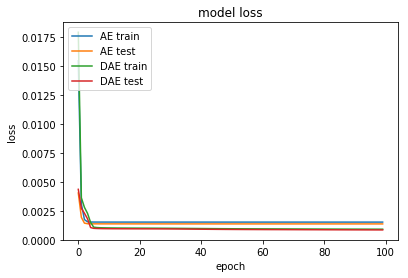

In [161]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(deep_results[0].history['loss'])
plt.plot(deep_results[0].history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['AE train', 'AE test', "DAE train", "DAE test"], loc='upper left')
plt.show()

In [160]:
deep_results[0]